In [1]:
# Implementing the network structure from the paper https://arxiv.org/abs/1704.02019
# Associative Content Addressable Memory with Exponentially Many Robust Stable States
# By Rishidev Chaudhuri and Ila Fiete

In [2]:
# Goint in to really solve the oscillation issue
# I suspect the issue is this: http://www.robertmarks.org/REPRINTS/1987_SynchronousVsAsynchonousBehavior.pdf
# "Certain horizontal oscillations can be avoided by adopting appropriate thresholding rules. 
# We demonstrate, for example, that when (1) the states of neurons with an input sum of zero are assigned
# the complement of their previous state, (2) the net is operated asynchronously, 
# and (3) nonzero neural autoconnects are allowed, the net will not oscillate either vertically or horizontally."
# Made it asynchronous and also without any flipping when the input sum is zero...

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pprint
import time
%matplotlib inline

import matplotlib.cm as cm # color maps

/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
global_num_timesteps = 4500

In [5]:
# Bottom layer has N neurons, called input neurons
# Second layer is constraint layer, has N_c ~ N small sub-networks
# The small sub-networks are called constraint nodes
# ith input neuron connects to z_i constraint nodes
# jth constraint node connects to z_j_c input neurons

# Each neuron in a given constraint node is connected to the same set of input neurons

# M is the number of neurons in each constraint node

In [6]:
def matching_assignment(N, N_c, z, z_c):
    
    start = time.time()
    
    if N_c * z_c != N * z:
        print "MISMATCHED SIZES"

    outgoing_edges_left = []
    for i in range(N):
        for j in range(z):
            outgoing_edges_left.append((i,"?"))

    incoming_edges_right = []
    for k in range(N_c):
        for l in range(z_c):
            incoming_edges_right.append(("?", k))

    matches = []
    while len(matches) < N*z:
        random_index_left = np.random.randint(0, len(outgoing_edges_left), size=1)[0]
        random_index_right = np.random.randint(0, len(incoming_edges_right), size=1)[0]
        s = (outgoing_edges_left[random_index_left][0], incoming_edges_right[random_index_right][1])
        if not s in matches:
            matches.append(s)
            outgoing_edges_left.pop(random_index_left)
            incoming_edges_right.pop(random_index_right)
        if time.time() - start > 10: # This is to re-start if it doesn't find a good assignment on this round
            print "Trying another assignment..."
            return matching_assignment(N, N_c, z, z_c)
        
    input_to_constraint_node_connectivity = []
    for n in range(N):
        outgoing = []
        for o in matches:
            if o[0] == n:
                outgoing.append(o[1])
        input_to_constraint_node_connectivity.append(outgoing)
        
    return input_to_constraint_node_connectivity

N = 24
N_c = 10
z = 5
z_c_avg = 12
r = 5
M_typical = 128


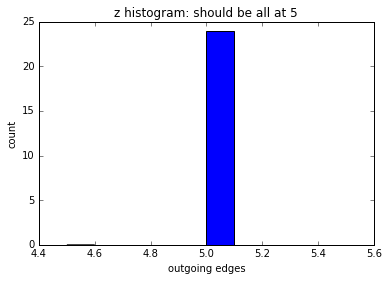


total outgoing edges
120


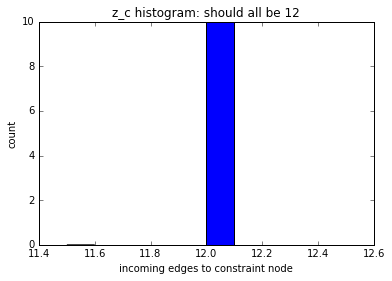


total incoming edges
120


In [7]:
# First define the input to constraint node connectivity

N = 24 # Should be a multiple of 12
print "N = %i" % N

N_c = int(5*N/12)
print "N_c = %i" % N_c

z = 5 # Should be 5
print "z = %i" % z

z_c_avg = int(N*z/N_c)
print "z_c_avg = %i" % z_c_avg

r = 5
print "r = %i" % r

M_typical = 2**(z_c_avg-r)
print "M_typical = %i" % M_typical

input_to_constraint_node_connectivity = matching_assignment(N, N_c, z, z_c_avg)
    
constraint_node_to_input_connectivity = []
for i in range(N_c):
    temp = []
    for j in range(N):
        if i in input_to_constraint_node_connectivity[j]:
            temp.append(j)
    constraint_node_to_input_connectivity.append(temp)
    
plt.figure()
plt.title("z histogram: should be all at 5")
plt.xlabel("outgoing edges")
plt.ylabel("count")
plt.hist([len(q) for q in input_to_constraint_node_connectivity])
plt.show()

print "\ntotal outgoing edges"
print np.sum([len(q) for q in input_to_constraint_node_connectivity])

plt.figure()
plt.title("z_c histogram: should all be 12")
plt.xlabel("incoming edges to constraint node")
plt.ylabel("count")
plt.hist([len(q) for q in constraint_node_to_input_connectivity])
plt.show()

print "\ntotal incoming edges"
print np.sum([len(q) for q in constraint_node_to_input_connectivity])

In [8]:
def generate_random_parity_states(input_size, num_parity_states_to_generate):
    parity_states = []
    for i in range(num_parity_states_to_generate):
        parity = 1
        state = []
        while parity == 1:
            state = np.random.randint(0,2,size = input_size)
            parity = sum(state) % 2
            if state in parity_states:
                parity = 1 # A hack to make sure all the permitted parity states in a node are distinct
            if parity == 0:
                parity_states.append(state)

    return parity_states

print generate_random_parity_states(12, 1)

[array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1])]


In [9]:
def M_for_constraint_node(constraint_node_index):
    z_c_for_this_node = len(constraint_node_to_input_connectivity[constraint_node_index])
    return 2**(z_c_for_this_node - r)

In [10]:
def generate_constraint_node_neurons(constraint_node_index):
    neurons = []
    z_c_for_this_node = len(constraint_node_to_input_connectivity[constraint_node_index])
    M_for_this_node = M_for_constraint_node(constraint_node_index)
    for i in range(M_for_this_node):
        neuron = {}
        neuron["inputs"] = constraint_node_to_input_connectivity[constraint_node_index]
        neuron["num_inputs"] = len(neuron["inputs"])
        neuron["preferred_parity_config"] = generate_random_parity_states(neuron["num_inputs"], 1)[0]
        neuron["ons_preferred"] = [neuron["inputs"][j] for j in range(neuron["num_inputs"]) if neuron["preferred_parity_config"][j] == 1] 
        neuron["offs_preffered"] = [neuron["inputs"][j] for j in range(neuron["num_inputs"]) if neuron["preferred_parity_config"][j] == 0]
        neuron["bias_term"] = neuron["num_inputs"] - np.sum(neuron["preferred_parity_config"])
        neurons.append(neuron)

    return neurons

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(generate_constraint_node_neurons(N_c-1)[0]) # Show what the first neuron in the last constraint node looks like

{   'bias_term': 8,
    'inputs': [4, 6, 9, 10, 11, 13, 14, 16, 17, 18, 20, 23],
    'num_inputs': 12,
    'offs_preffered': [6, 10, 11, 13, 14, 16, 17, 23],
    'ons_preferred': [4, 9, 18, 20],
    'preferred_parity_config': array([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0])}


In [11]:
def get_full_index(constraint_node_index, index_within_node):
    return N + sum([M_for_constraint_node(k) for k in range(constraint_node_index)]) + index_within_node

In [12]:
# Generating the full weight matrix and biases

last_constraint_node_index = N_c-1

last_neuron_in_last_constraint_node_index = M_for_constraint_node(last_constraint_node_index) - 1

total_number_neurons = get_full_index(last_constraint_node_index, last_neuron_in_last_constraint_node_index) + 1
total_number_neurons = int(total_number_neurons) # Not sure why it is making me do this
print "total number of neurons %i" % total_number_neurons
 
full_weight_matrix = np.array([[0.0 for j in range(total_number_neurons)] for i in range(total_number_neurons)], dtype = np.float64)

biases = np.array([0.0 for j in range(total_number_neurons)], dtype = np.float64)

for node in range(N_c): # Index over constraint nodes
    neurons_in_node = generate_constraint_node_neurons(node) # Generate neurons in that constraint node
    z_c_for_this_node = len(constraint_node_to_input_connectivity[node])
    M_for_this_node = M_for_constraint_node(node)
    for m in range(M_for_this_node):
        neuron_full_index = get_full_index(node, m)
        neuron = neurons_in_node[m]
        for g in neuron["ons_preferred"]: # Constraint neuron to input neuron and vice versa
            full_weight_matrix[neuron_full_index][g] = 1
            full_weight_matrix[g][neuron_full_index] = 1
        for g in neuron["offs_preffered"]: # Constraint neuron to input neuron and vice versa
            full_weight_matrix[neuron_full_index][g] = -1
            full_weight_matrix[g][neuron_full_index] = -1
        for p in range(m, M_for_this_node): # Inhibitory internal connectivity within the same node
            p_full_index = get_full_index(node, p)
            if p != m:
                full_weight_matrix[neuron_full_index][p_full_index] = -1*(neuron["num_inputs"] - 1)
                full_weight_matrix[p_full_index][neuron_full_index] =  -1*(neuron["num_inputs"] - 1)
        biases[neuron_full_index] = neuron["bias_term"]

total number of neurons 1304


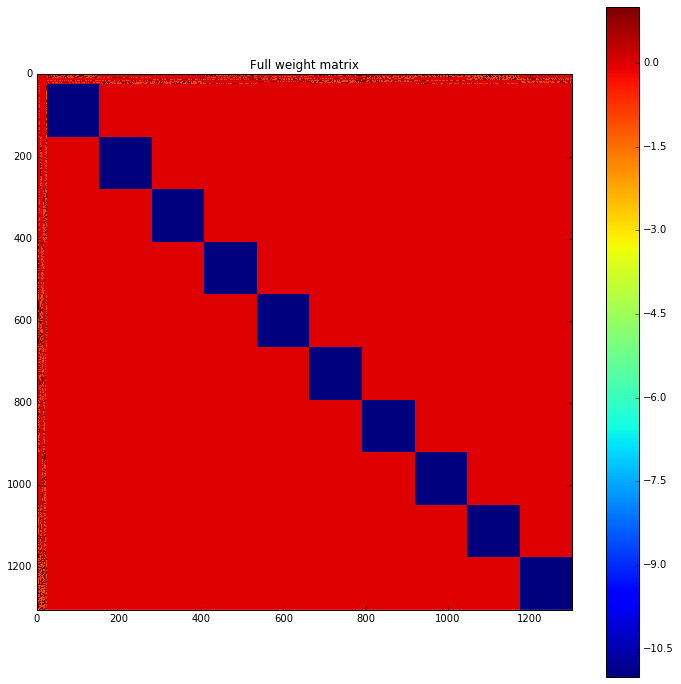

In [13]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.figure()
plt.title("Full weight matrix")
plt.imshow(full_weight_matrix, interpolation='none')
plt.colorbar()
plt.show()

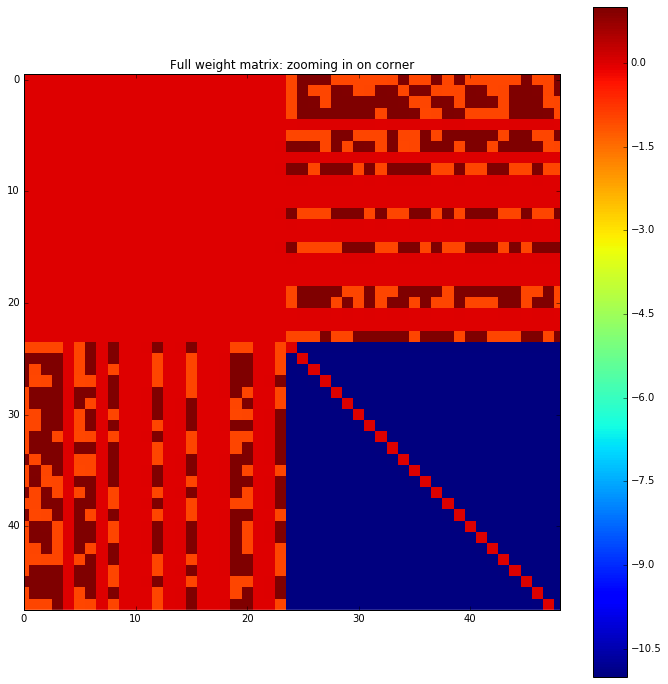

In [14]:
plt.figure()
plt.title("Full weight matrix: zooming in on corner")
corner = full_weight_matrix[:2*N][:2*N]
plt.imshow(corner, interpolation='none')
plt.xlim(0.0, 2*N)
plt.colorbar()
plt.show()

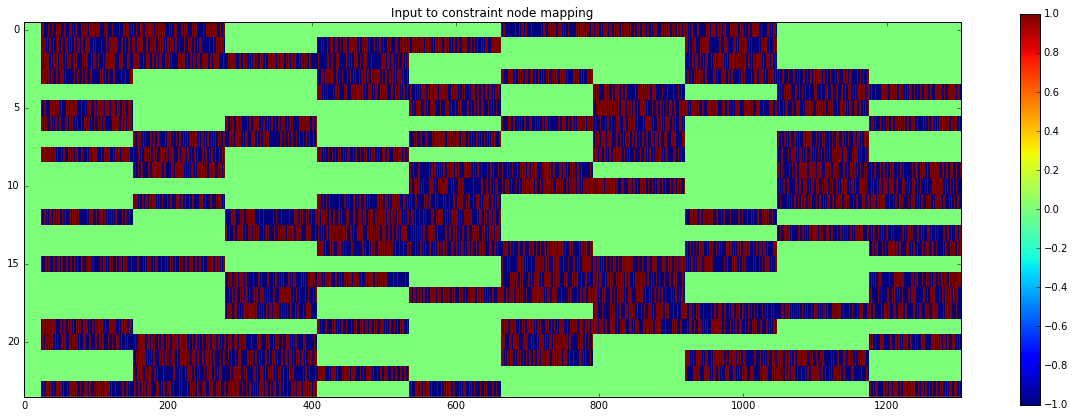

In [15]:
plt.rcParams['figure.figsize'] = (21, 7)
plt.figure()
plt.title("Input to constraint node mapping")
adj = full_weight_matrix[:N][:]
plt.imshow(adj, interpolation='none', aspect = 0.4*float(total_number_neurons)/float(N))
plt.colorbar()

plt.show()

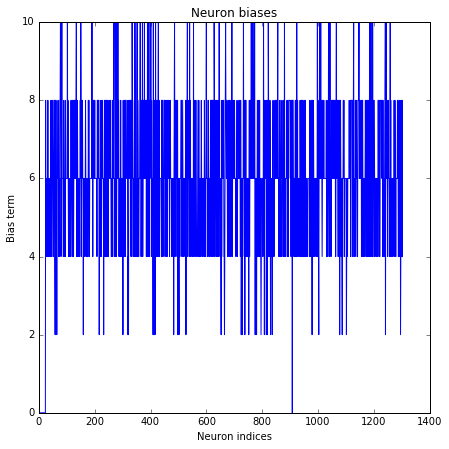

In [16]:
plt.rcParams['figure.figsize'] = (7, 7)
plt.figure()
plt.title("Neuron biases")
plt.xlabel("Neuron indices")
plt.ylabel("Bias term")
plt.plot(biases)
plt.show()

In [17]:
# Defining some Hopfield aspects

def random_state(num_neurons):
    return np.random.randint(0,2,size = num_neurons)

def time_step(state, weight_matrix, biases): # Asynchronous mode

    k = np.random.randint(0, len(state), size=1)[0] # Pick a random single neuron to update
    
    a = 0.0
    for j in range(len(state)):
        if j != k:
            a += weight_matrix[k][j] * state[j]
    a += biases[k]
        
    ns = state
        
    if a > 0.0:
        ns[k] = 1.0
    elif a < 0.0:
        ns[k] = 0.0
    elif a == 0.0: # If the activation is exactly zero
        pass
        #coin_flip = float(np.random.randint(0,2, size=1)[0])
        #ns[k] = float(coin_flip)
                        
    return np.array(ns, dtype = np.float64)

def energy(s, weights, bias):
    s_plusminus = [(-1)**q for q in s]
    x = np.array(s_plusminus)
    W = np.array(weights)
    b = np.array(bias)
    E = (1/2)*np.matmul(np.matmul(np.transpose(x), W), x) + np.dot(x,b)
    return -1.0 * E

def small_perturbation(perturb_size, state):
    new_state = np.zeros(len(state))
    prob = float(perturb_size)/float(len(state))
    for i in range(len(state)):
        if np.random.rand() < prob:
            new_state[i] = (state[i] + 1) % 2
        else:
            new_state[i] = state[i]
    return np.array(new_state, dtype = np.float64)

energy 282.000000 [ 0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.
  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
energy -7366.000000 [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

___Recovery from Perturbation___
Percentage perturbed: 4.000000
energy -6754.000000 [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
energy -7614.000000 [ 0.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


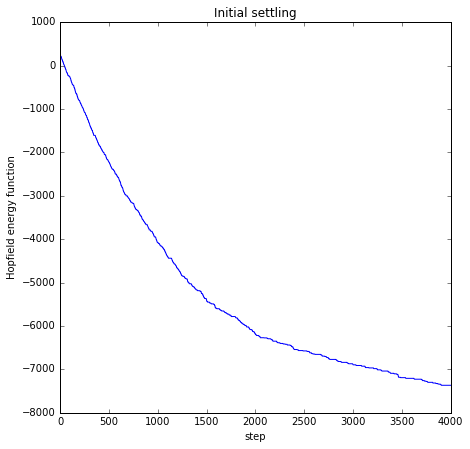

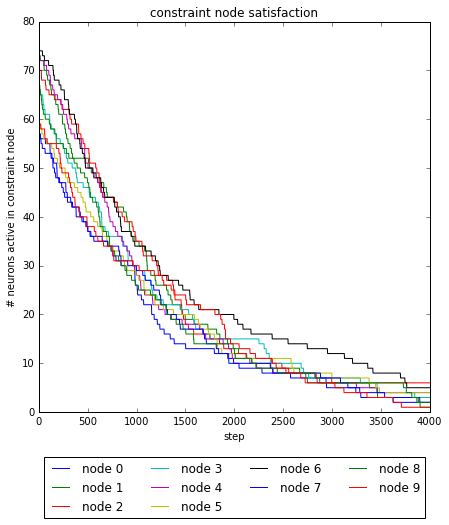

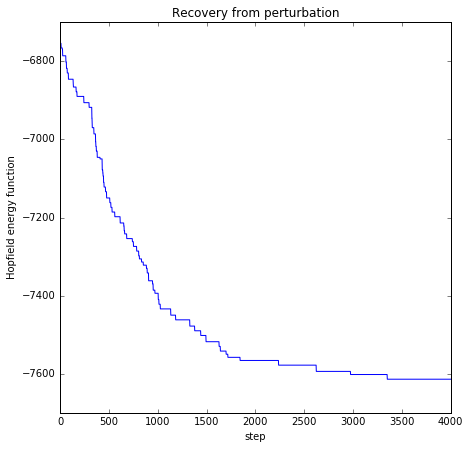

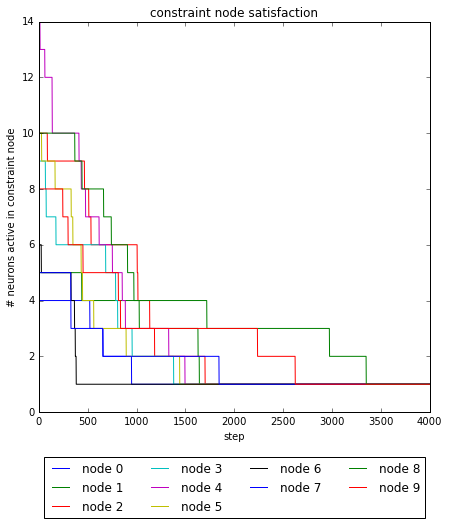

In [18]:
# Test out some Hopfield dynamics
initial_random_state = random_state(total_number_neurons)

num_timesteps = global_num_timesteps
state = np.array(initial_random_state, dtype = np.float64)
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
    
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Initial settling")
plt.plot(energies)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)

print "\n___Recovery from Perturbation___"
perturb_percent = 4.0
print "Percentage perturbed: %f" % perturb_percent
perturbed_state = small_perturbation(perturb_percent * total_number_neurons / 100.0, state)
num_timesteps = global_num_timesteps
state = perturbed_state
energies = []
e = energy(state, full_weight_matrix, biases)

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

print "energy %f" % e, state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
    
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Recovery from perturbation")
plt.plot(energies)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)

energy -7646.000000 [ 0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  1.  1.
  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
energy -7630.000000 [ 0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.  1.  1.  1.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

___Recovery from Perturbation___
Percentage perturbed: 4.000000
energy -7198.000000 [ 0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
energy -7606.000000 [ 0.  1.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


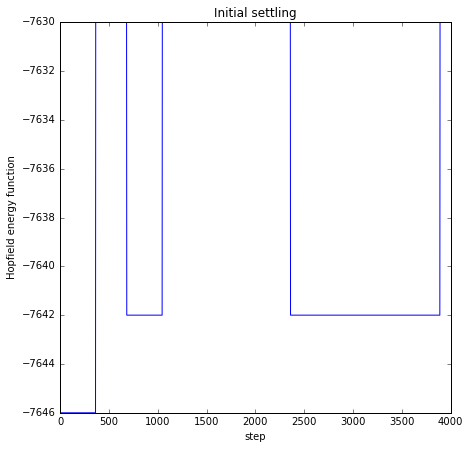

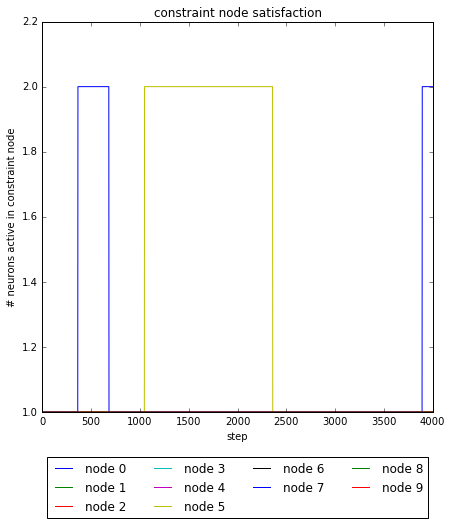

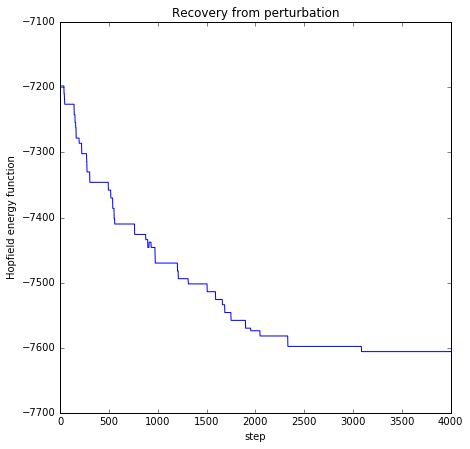

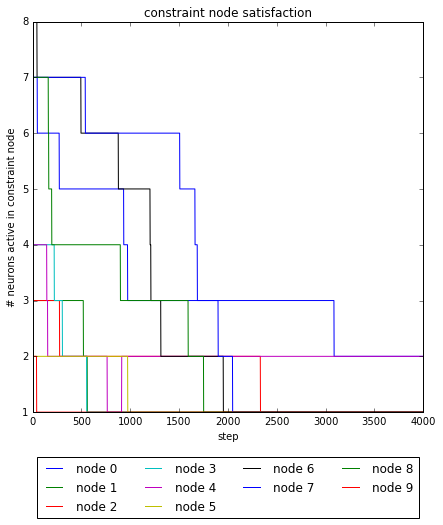

In [19]:
initial_nonrandom_state = np.ndarray.tolist(random_state(N)) # Visible nodes random
initial_nonrandom_state.extend([0.0 for j in range(total_number_neurons - N)])
for node in range(N_c): # Set just one neuron in each constraint node to be 1
    M_for_this_node = M_for_constraint_node(node)
    m = np.random.randint(0,M_for_this_node)
    neuron_full_index = get_full_index(node, m)
    initial_nonrandom_state[neuron_full_index] = 1.0
    
num_timesteps = global_num_timesteps
state = np.array(initial_nonrandom_state, dtype = np.float64)
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
    
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Initial settling")
plt.plot(energies)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)

print "\n___Recovery from Perturbation___"
perturb_percent = 4.0
print "Percentage perturbed: %f" % perturb_percent
perturbed_state = small_perturbation(perturb_percent * total_number_neurons / 100.0, state)
num_timesteps = global_num_timesteps
state = perturbed_state
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
    
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Recovery from perturbation")
plt.plot(energies)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)

energy -7626.000000 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
energy -7626.000000 [ 1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.
  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

___Recovery from Perturbation___
Percentage perturbed: 4.000000
energy -6906.000000 [ 1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.
  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
energy -7622.000000 [ 1.  1.  0.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


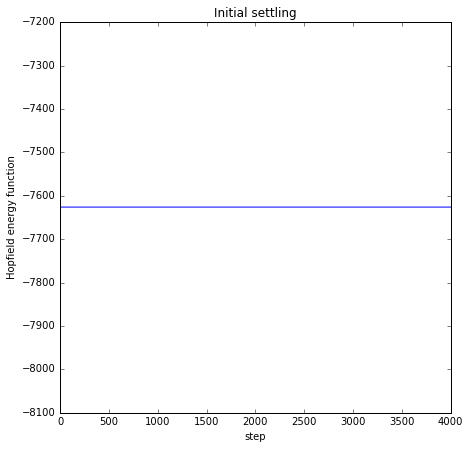

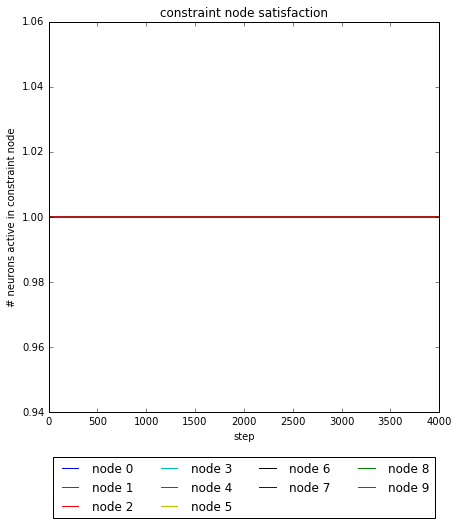

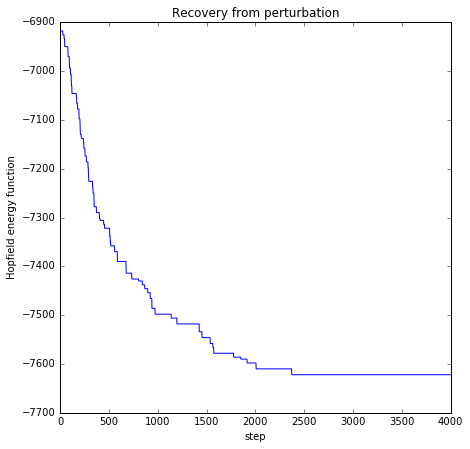

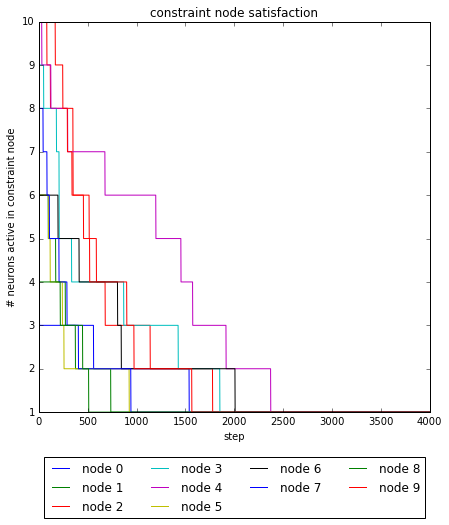

In [20]:
initial_nonrandom_state = np.ndarray.tolist(np.zeros(N)) # Visible nodes zero
initial_nonrandom_state.extend([0.0 for j in range(total_number_neurons - N)])
for node in range(N_c): # Set just one neuron in each constraint node to be 1
    M_for_this_node = M_for_constraint_node(node)
    m = np.random.randint(0,M_for_this_node)
    neuron_full_index = get_full_index(node, m)
    initial_nonrandom_state[neuron_full_index] = 1.0
    
num_timesteps = global_num_timesteps
state = np.array(initial_nonrandom_state, dtype = np.float64)
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
    
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Initial settling")
plt.plot(energies)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)

print "\n___Recovery from Perturbation___"
perturb_percent = 4.0
print "Percentage perturbed: %f" % perturb_percent
perturbed_state = small_perturbation(perturb_percent * total_number_neurons / 100.0, state)
num_timesteps = global_num_timesteps
state = perturbed_state
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
    
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Recovery from perturbation")
plt.plot(energies)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)